<a href="https://colab.research.google.com/github/mrbadrul/MANB2153/blob/master/Final_Workspace_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link Google Colab to Kaggle

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
#Download kaggle.json from Kaggle
#Import json into notebook 
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"buahkiwi","key":"21ab1cc215db77b0d01cda015837f71c"}'}

In [0]:
#authenticate json content
!cp kaggle.json ~/.kaggle/
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json

total 4
-rw-r--r-- 1 root root 64 May 22 17:37 kaggle.json
{"username":"buahkiwi","key":"21ab1cc215db77b0d01cda015837f71c"}

In [0]:
#Install kaggle packages
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 3.7MB/s 
     |████████████████████████████████| 5.3MB 9.2MB/s 
     |████████████████████████████████| 112kB 36.6MB/s 
     |████████████████████████████████| 102kB 25.9MB/s 
     |████████████████████████████████| 51kB 17.9MB/s 


Download the dataset to Google Colab

In [0]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

 99% 1.47G/1.49G [00:13<00:00, 151MB/s]
100% 1.49G/1.49G [00:13<00:00, 115MB/s]


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('breast-histopathology-images.zip', 'r')
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile('IDC_regular_ps50_idx5.zip', 'r')
zip_ref.extractall('BreastCancer')
zip_ref.close()

Start Data Exploration

In [0]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
#from scipy.misc import imresize, imread
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

Using TensorFlow backend.


In [0]:
from os import listdir
listdir('/content/BreastCancer')[:10]

['12820',
 '10262',
 '12870',
 '10259',
 '12955',
 '12879',
 '14212',
 '13692',
 '10308',
 '10291']

In [0]:
imagePatches = glob('/content/BreastCancer/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

/content/BreastCancer/12820/0/12820_idx5_x1251_y551_class0.png
/content/BreastCancer/12820/0/12820_idx5_x3351_y1151_class0.png
/content/BreastCancer/12820/0/12820_idx5_x1851_y1001_class0.png
/content/BreastCancer/12820/0/12820_idx5_x3401_y151_class0.png
/content/BreastCancer/12820/0/12820_idx5_x401_y951_class0.png
/content/BreastCancer/12820/0/12820_idx5_x1401_y1351_class0.png
/content/BreastCancer/12820/0/12820_idx5_x1701_y1301_class0.png
/content/BreastCancer/12820/0/12820_idx5_x3201_y151_class0.png
/content/BreastCancer/12820/0/12820_idx5_x1601_y1151_class0.png
/content/BreastCancer/12820/0/12820_idx5_x2651_y1551_class0.png


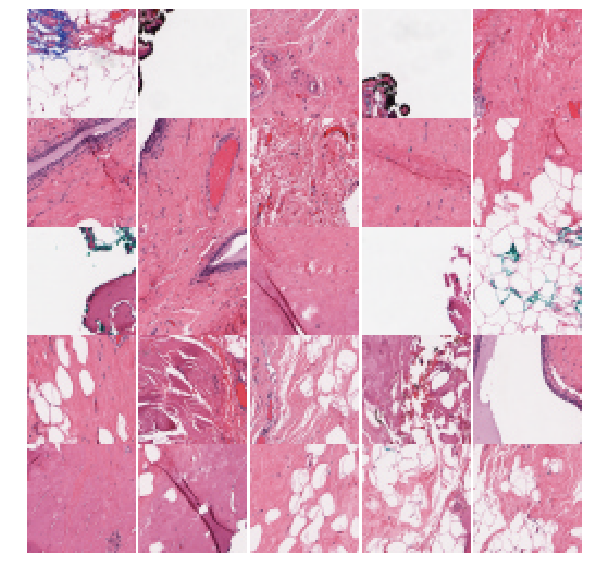

In [0]:
# Plot Multiple Images
bunchOfImages = imagePatches
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in bunchOfImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (50, 50)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

In [0]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['/content/BreastCancer/12820/0/12820_idx5_x1251_y551_class0.png', '/content/BreastCancer/12820/0/12820_idx5_x3351_y1151_class0.png', '/content/BreastCancer/12820/0/12820_idx5_x1851_y1001_class0.png', '/content/BreastCancer/12820/0/12820_idx5_x3401_y151_class0.png', '/content/BreastCancer/12820/0/12820_idx5_x401_y951_class0.png'] 

IDC(+)

 ['/content/BreastCancer/12820/1/12820_idx5_x2851_y401_class1.png', '/content/BreastCancer/12820/1/12820_idx5_x1401_y401_class1.png', '/content/BreastCancer/12820/1/12820_idx5_x2851_y1051_class1.png', '/content/BreastCancer/12820/1/12820_idx5_x2801_y401_class1.png', '/content/BreastCancer/12820/1/12820_idx5_x1801_y601_class1.png']


In [0]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

Select 60,000 images

In [0]:
X,Y = proc_images(0,60000)

In [0]:
X1 = np.array(X)
X1.shape

(60000, 50, 50, 3)

In [0]:
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y

In [0]:
X2=df["images"]
Y2=df["labels"]

In [0]:
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1] 

In [0]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)

Total number of images: 60000
Number of IDC(-) Images: 41676
Number of IDC(+) Images: 18324
Percentage of positive images: 30.54%
Image shape (Width, Height, Channels): (50, 50, 3)


Start with train and test

In [0]:
X=np.array(X)
X=X/255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [0]:
del X
del X1,X2
del Y2
del imgs0,imgs1
import gc
gc.collect()

489

In [0]:
X_train.shape

(48000, 50, 50, 3)

In [0]:
X_test.shape

(12000, 50, 50, 3)

In [0]:
#Distribution of Labels
dist = df['labels'].value_counts()
dist

0    41676
1    18324
Name: labels, dtype: int64

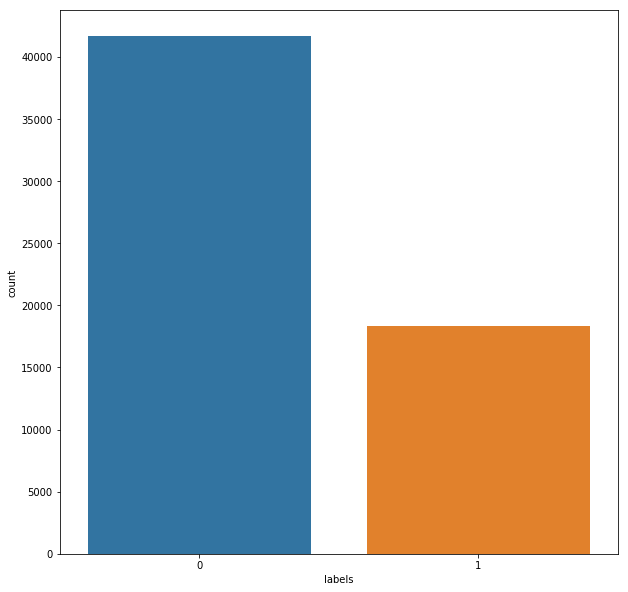

In [0]:
sns.countplot(df['labels'])

One Hot encoding

In [0]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(Y_train, num_classes = 2)
y_testHot = to_categorical(Y_test, num_classes = 2)

1. Helper Functions

In [0]:
# Helper Functions  Learning Curves and Confusion Matrix

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

Configure CNN

In [0]:
batch_size = 128
num_classes = 2
epochs = 8
img_rows,img_cols=50,50
input_shape = (img_rows, img_cols, 3)
e = 2

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,strides=e))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

In [0]:
a = X_train
b = y_trainHot
c = X_test
d = y_testHot
epochs = 10

In [0]:
history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, 
                              epochs=epochs,validation_data = [c, d],
                              callbacks = [MetricsCheckpoint('logs')])

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
1500/1500 [==============================] - 202s 135ms/step - loss: 0.4836 - acc: 0.7779 - val_loss: 0.3977 - val_acc: 0.8217
Epoch 2/10
1500/1500 [==============================] - 199s 133ms/step - loss: 0.4223 - acc: 0.8164 - val_loss: 0.3790 - val_acc: 0.8377
Epoch 3/10
1500/1500 [==============================] - 200s 134ms/step - loss: 0.3978 - acc: 0.8265 - val_loss: 0.3585 - val_acc: 0.8462
Epoch 4/10
1500/1500 [==============================] - 199s 133ms/step - loss: 0.3864 - acc: 0.8340 - val_loss: 0.3484 - val_acc: 0.8496
Epoch 5/10
1500/1500 [==============================] - 200s 134ms/step - loss: 0.3751 - acc: 0.8397 - val_loss: 0.3452 - val_acc: 0.8522
Epoch 6/10
1500/1500 [==============================] - 201s 134ms/step - loss: 0.3671 - acc: 0.8429 - val_loss: 0.3489 - val_acc: 0.8494
Epoch 7/10
1500/1500 [==============================] - 201s 134ms/step - loss: 0.3599 - acc: 0.8458 - val_loss: 0.3643 - va

In [0]:
y_pred = model.predict(c)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(d,axis=1)
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}

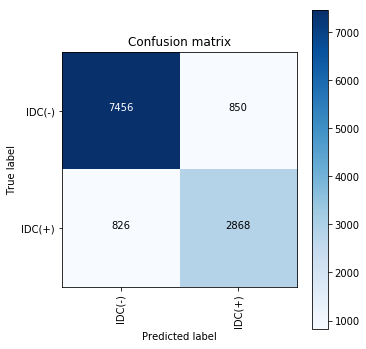

In [0]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()

In [0]:
	
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


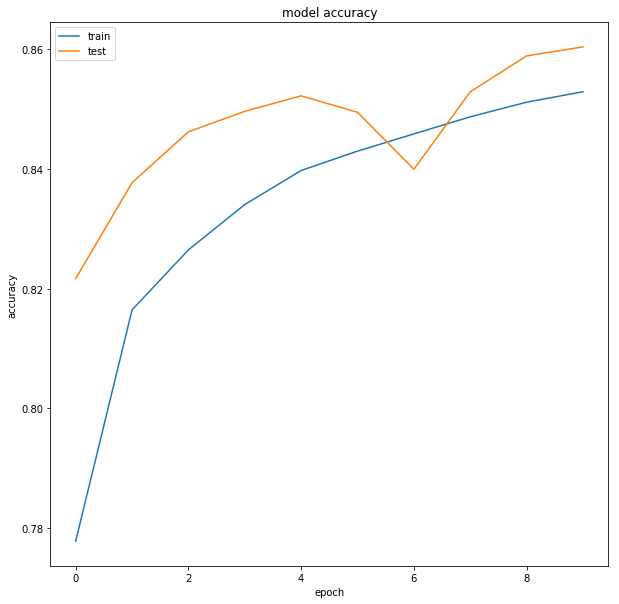

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

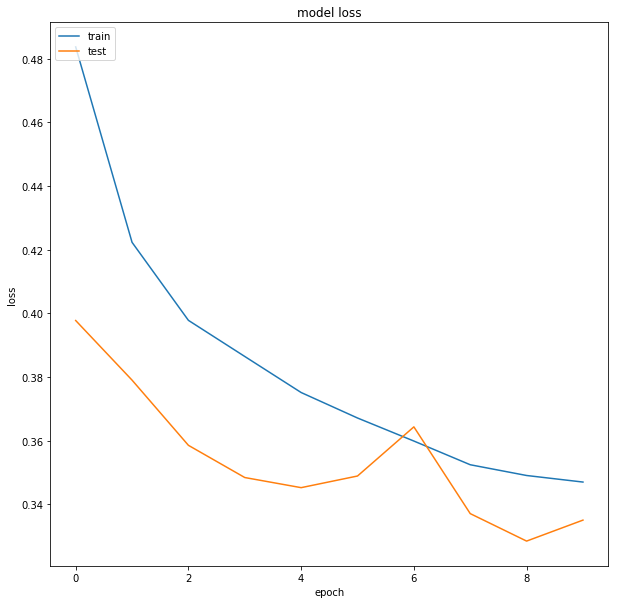

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()